# Predicting Sunspots with Neural Networks

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [3]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-04-27 04:25:42--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.171.207, 142.251.120.207, 142.251.161.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.171.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-04-27 04:25:42 (125 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



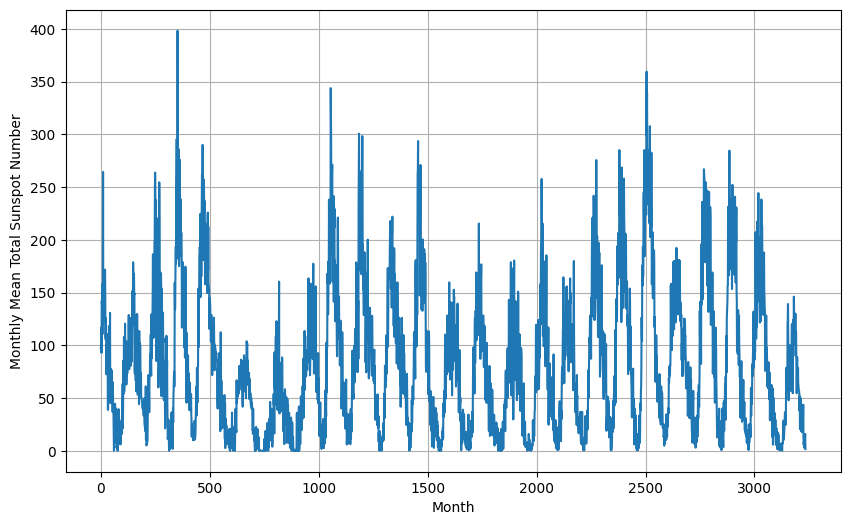

In [4]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [5]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

In [8]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

## Tune the Learning Rate

In [9]:
# Get initial weights
init_weights = model.get_weights()

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 8s 14ms/step - loss: 86.7719 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 13ms/step - loss: 57.5503 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 9ms/step - loss: 42.9256 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 37.8718 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 9ms/step - loss: 35.8070 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 9ms/step - loss: 34.6245 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 33.6938 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 8ms/step - loss: 32.7009 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 31.6515 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 30.5390 - lr: 2.8184e-08
Epoch 11/100
93/9

(1e-08, 0.001, 0.0, 100.0)

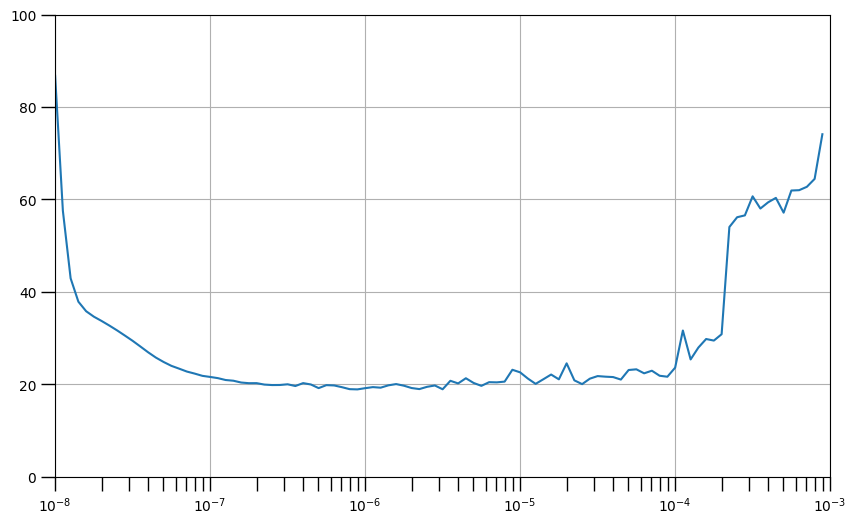

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [13]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 4s 10ms/step - loss: 32.7436 - mae: 33.2404
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 22.2857 - mae: 22.7797
Epoch 3/100
93/93 [==============================] - 1s 9ms/step - loss: 21.5095 - mae: 22.0039
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 20.8363 - mae: 21.3295
Epoch 5/100
93/93 [==============================] - 1s 9ms/step - loss: 21.3206 - mae: 21.8137
Epoch 6/100
93/93 [==============================] - 1s 9ms/step - loss: 20.1770 - mae: 20.6714
Epoch 7/100
93/93 [==============================] - 1s 14ms/step - loss: 19.9992 - mae: 20.4927
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 19.5671 - mae: 20.0601
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 19.2436 - mae: 19.7362
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 18.9722 - mae: 19.4665
Epoch 11/100
93/93 [=================

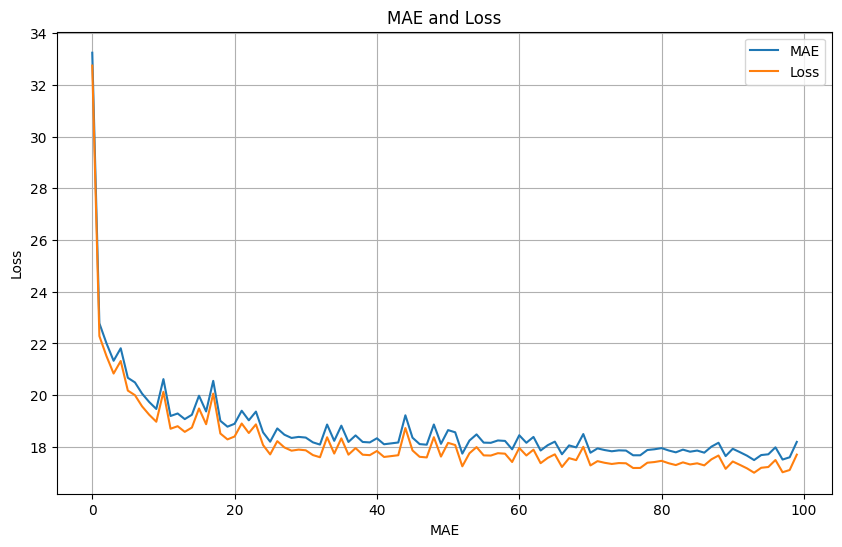

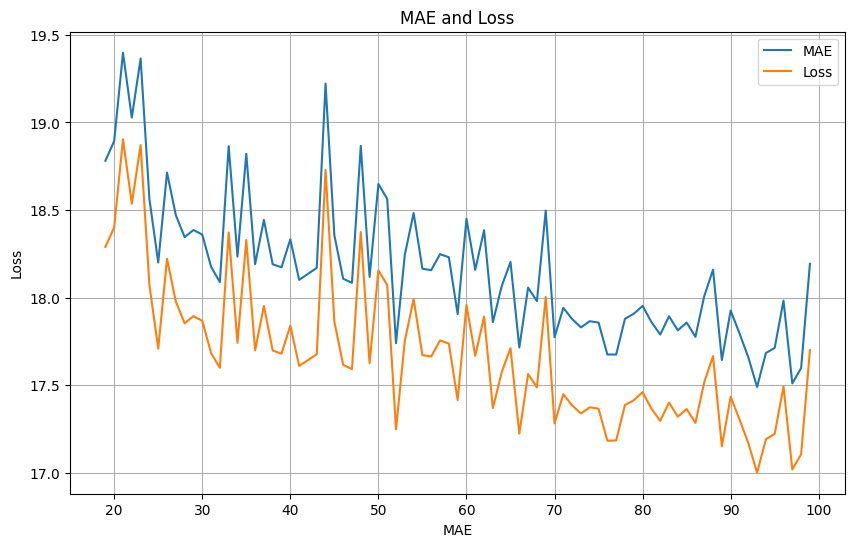

In [15]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

In [16]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 [==============================] - 1s 18ms/step


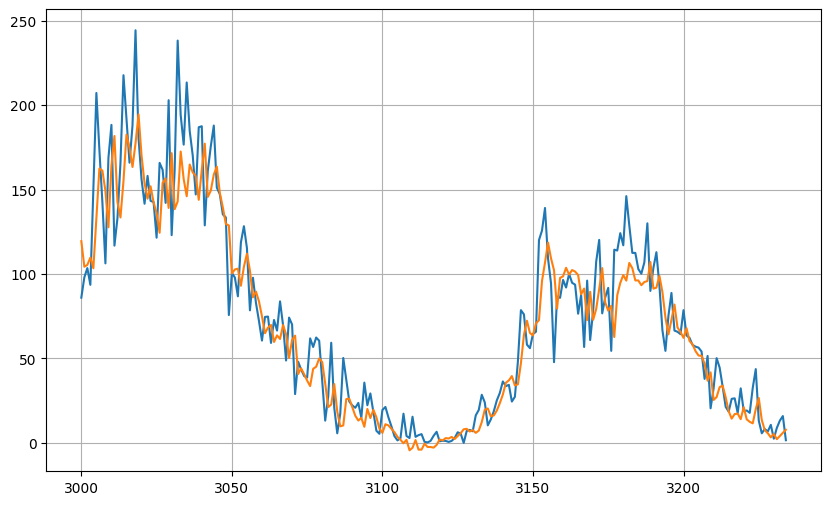

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [18]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.94221


## Optional

In [19]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
93/93 [==============================] - 4s 10ms/step - loss: 16.6972 - mae: 17.1881
Epoch 2/10
93/93 [==============================] - 1s 9ms/step - loss: 16.6241 - mae: 17.1148
Epoch 3/10
93/93 [==============================] - 1s 9ms/step - loss: 16.6313 - mae: 17.1214
Epoch 4/10
93/93 [==============================] - 1s 9ms/step - loss: 16.6214 - mae: 17.1111
Epoch 5/10
93/93 [==============================] - 1s 10ms/step - loss: 16.6216 - mae: 17.1116
Epoch 6/10
93/93 [==============================] - 1s 14ms/step - loss: 16.6256 - mae: 17.1144
Epoch 7/10
93/93 [==============================] - 1s 11ms/step - loss: 16.6477 - mae: 17.1387
Epoch 8/10
93/93 [==============================] - 1s 9ms/step - loss: 16.6261 - mae: 17.1143
Epoch 9/10
93/93 [==============================] - 1s 9ms/step - loss: 16.6220 - mae: 17.1111
Epoch 10/10
93/93 [==============================] - 1s 13ms/step - loss: 16.6290 - mae: 17.1181


In [20]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
93/93 [==============================] - 5s 15ms/step - loss: 16.5786 - mae: 17.0687
Epoch 2/40
93/93 [==============================] - 1s 9ms/step - loss: 16.6866 - mae: 17.1758
Epoch 3/40
93/93 [==============================] - 1s 9ms/step - loss: 16.6348 - mae: 17.1258
Epoch 4/40
93/93 [==============================] - 1s 9ms/step - loss: 16.6232 - mae: 17.1134
Epoch 5/40
93/93 [==============================] - 1s 9ms/step - loss: 16.5822 - mae: 17.0722
Epoch 6/40
93/93 [==============================] - 1s 10ms/step - loss: 16.5615 - mae: 17.0519
Epoch 7/40
93/93 [==============================] - 1s 10ms/step - loss: 16.5734 - mae: 17.0634
Epoch 8/40
93/93 [==============================] - 1s 9ms/step - loss: 16.5921 - mae: 17.0826
Epoch 9/40
93/93 [==============================] - 1s 9ms/step - loss: 16.5878 - mae: 17.0774
Epoch 10/40
93/93 [==============================] - 1s 9ms/step - loss: 16.5676 - mae: 17.0582
Epoch 11/40
93/93 [===========================

8/8 [==============================] - 1s 7ms/step


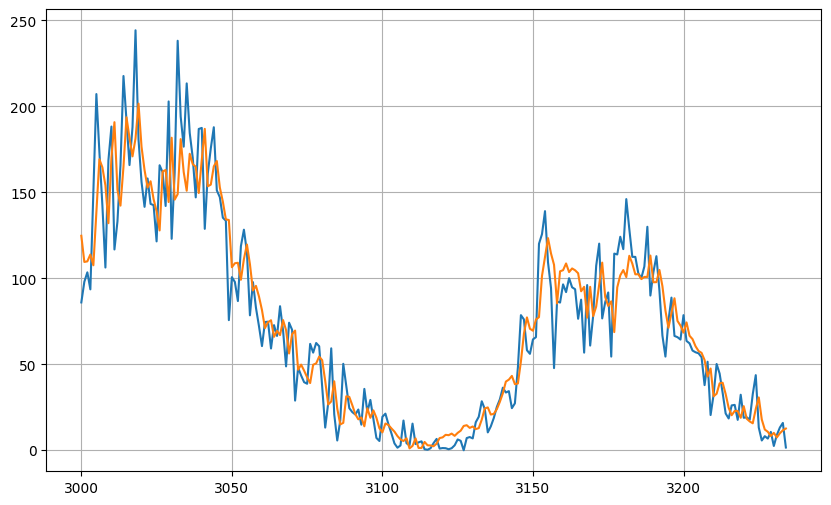

In [21]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [22]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.750484